In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor,
                              VotingClassifier, VotingRegressor, GradientBoostingClassifier,
                              GradientBoostingRegressor, AdaBoostClassifier)
from sklearn.metrics import (classification_report, confusion_matrix, mean_squared_error,
                             accuracy_score, cohen_kappa_score, r2_score, make_scorer)
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor 
from scipy.optimize import minimize

from keras.models import Model
from keras.layers import Input, Dense

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import torch
import torch.nn as nn
import torch.optim as optim

# Progress Report #1

# Importing Data

In [2]:
# Load Data

train_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
data_dict = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')

# Data Preparation

In [3]:
# Get Statistical details

train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Basic_Demos-Age,3960.0,10.433586,3.574648,5.0,8.00000,10.000000,13.000000,22.000000
Basic_Demos-Sex,3960.0,0.372727,0.483591,0.0,0.00000,0.000000,1.000000,1.000000
CGAS-CGAS_Score,2421.0,65.454771,22.341862,25.0,59.00000,65.000000,75.000000,999.000000
Physical-BMI,3022.0,19.331929,5.113934,0.0,15.86935,17.937682,21.571244,59.132048
Physical-Height,3027.0,55.946713,7.473764,33.0,50.00000,55.000000,62.000000,78.500000
...,...,...,...,...,...,...,...,...
PCIAT-PCIAT_Total,2736.0,27.896199,20.338853,0.0,12.00000,26.000000,41.000000,93.000000
SDS-SDS_Total_Raw,2609.0,41.088923,10.427433,17.0,33.00000,39.000000,46.000000,96.000000
SDS-SDS_Total_T,2606.0,57.763622,13.196091,38.0,47.00000,55.000000,64.000000,100.000000
PreInt_EduHx-computerinternet_hoursday,3301.0,1.060588,1.094875,0.0,0.00000,1.000000,2.000000,3.000000


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   Basic_Demos-Enroll_Season               20 non-null     object 
 2   Basic_Demos-Age                         20 non-null     int64  
 3   Basic_Demos-Sex                         20 non-null     int64  
 4   CGAS-Season                             10 non-null     object 
 5   CGAS-CGAS_Score                         8 non-null      float64
 6   Physical-Season                         14 non-null     object 
 7   Physical-BMI                            13 non-null     float64
 8   Physical-Height                         13 non-null     float64
 9   Physical-Weight                         13 non-null     float64
 10  Physical-Waist_Circumference            5 non-null      float64


In [6]:
data_dict.head()

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


## EDA

Class Distribution:
 sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64


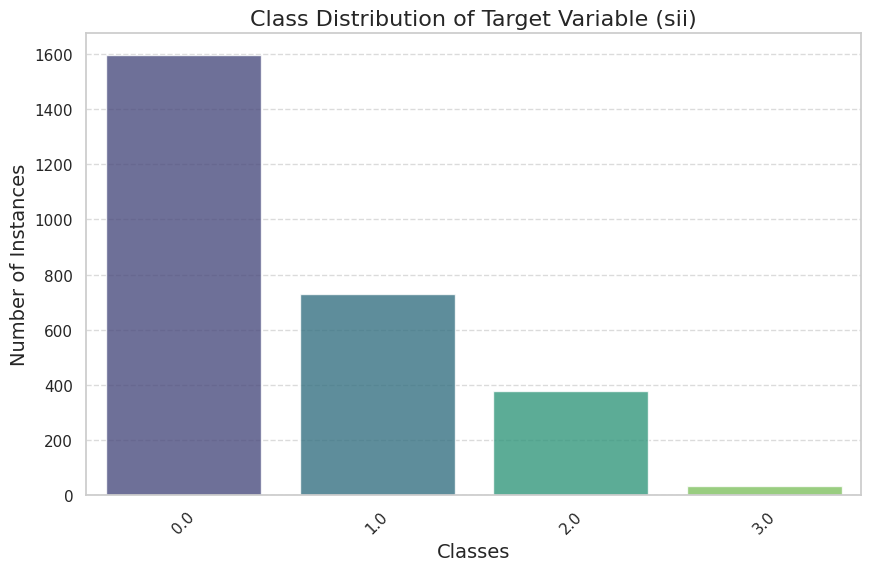

In [7]:
# Check the distribution of the target variable 'sii'
class_distribution = train_df['sii'].value_counts().sort_index()
print("Class Distribution:\n", class_distribution)

# Set the style for the plot
sns.set(style="whitegrid")

# Create a bar plot of class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis', alpha=0.8)

# Set the title and labels
plt.title('Class Distribution of Target Variable (sii)', fontsize=16)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Number of Instances', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: add gridlines for better readability

# Show the plot
plt.show()

In [8]:
def calculate_stats(data, columns):
    if isinstance(columns, str):
        columns = [columns]

    stats = []
    for col in columns:
        if data[col].dtype in ['object', 'category']:
            counts = data[col].value_counts(dropna=False, sort=False)
            percents = data[col].value_counts(normalize=True, dropna=False, sort=False) * 100
            formatted = counts.astype(str) + ' (' + percents.round(2).astype(str) + '%)'
            stats_col = pd.DataFrame({'count (%)': formatted})
            stats.append(stats_col)

        else:
            stats_col = data[col].describe().to_frame().transpose()
            stats_col['missing'] = data[col].isnull().sum()
            stats_col.index.name = col
            stats.append(stats_col)

    return pd.concat(stats, axis=0)

In [9]:
# Temporary variable to hold the new column
temp_data = train_df.copy()
temp_data['Age Group'] = pd.cut(
    temp_data['Basic_Demos-Age'],
    bins=[4, 12, 18, 22],
    labels=['Children (5-12)', 'Adolescents (13-18)', 'Adults (19-22)']
)

calculate_stats(temp_data, 'Age Group')

,count (%)
Age Group,
Children (5-12),2919 (73.71%)
Adolescents (13-18),953 (24.07%)
Adults (19-22),88 (2.22%)


In [10]:
sex_counts_renamed = train_df['Basic_Demos-Sex'].replace({0: 'Male', 1: 'Female'}).value_counts()
sex_counts_renamed

Basic_Demos-Sex
Male      2484
Female    1476
Name: count, dtype: int64

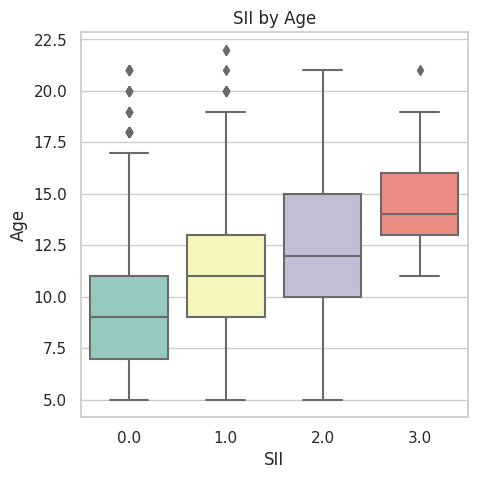

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the boxplot
fig, ax = plt.subplots(figsize=(5, 5))

# Create the boxplot for SII by Age without hue
sns.boxplot(y=train_df['Basic_Demos-Age'], x=train_df['sii'], ax=ax, palette="Set3")

# Set the title and labels
ax.set_title('SII by Age')  # Set the title on the ax object
ax.set_ylabel('Age')  # Set the y-axis label
ax.set_xlabel('SII')  # Set the x-axis label

# Show the plot
plt.show()

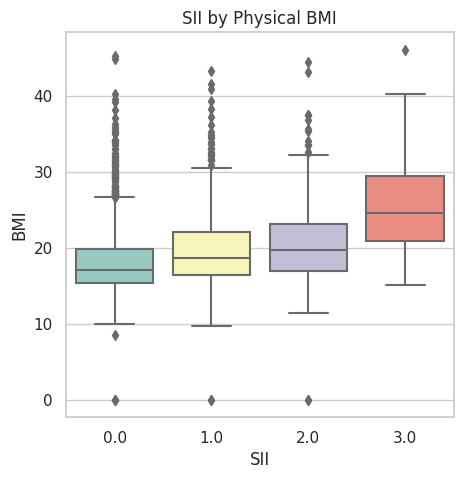

In [12]:
# Create the boxplot

fig, ax = plt.subplots(figsize=(5, 5)) 
sns.boxplot(y=train_df['Physical-BMI'], x=train_df['sii'], ax=ax, palette="Set3")  # Pass ax directly

# Set the title and labels
ax.set_title('SII by Physical BMI')  
ax.set_ylabel('BMI')  # Set the y-axis label
ax.set_xlabel('SII')  # Set the x-axis label

# Show the plot
plt.show()

---

# Data Preprocessing

In [13]:
common_columns = train_df.columns.intersection(test_df.columns)

In [14]:
# Create a copy of the original train_df for reference
train_original = train_df.copy()

# Filter train_df to keep only the common columns plus the 'sii' column
train_df = train_df[common_columns.union(['sii'])]

In [15]:
train_df

,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,...,Physical-Systolic_BP,Physical-Waist_Circumference,Physical-Weight,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,SDS-SDS_Total_Raw,SDS-SDS_Total_T,SDS-Season,id,sii
0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,...,NaN,NaN,50.8,Fall,3.0,NaN,NaN,NaN,00008ff9,2.0
1,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,...,122.0,22.0,46.0,Summer,0.0,46.0,64.0,Fall,000fd460,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,117.0,NaN,75.6,Summer,2.0,38.0,54.0,Fall,00105258,0.0
3,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,...,117.0,NaN,81.6,Winter,0.0,31.0,45.0,Summer,00115b9f,1.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0016bb22,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,3.0,4.52277,16.3642,1206.880,2051.70,19.46110,70.8117,14.0629,2.30138,11.58830,...,104.0,NaN,82.4,Fall,1.0,35.0,50.0,Winter,ff8a2de4,1.0
3956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,118.0,27.0,76.4,Winter,0.0,NaN,NaN,NaN,ffa9794a,NaN
3957,2.0,4.41305,21.4438,1253.740,2005.99,20.48250,75.8033,14.8043,6.63952,33.99670,...,116.0,NaN,109.8,Fall,0.0,56.0,77.0,Winter,ffcd4dbd,1.0
3958,4.0,6.66168,12.2372,1414.340,2970.12,26.53230,92.9092,13.0684,-0.83117,-5.90917,...,113.0,NaN,87.0,Spring,1.0,33.0,47.0,Spring,ffed1dd5,0.0


## Check for Duplicate Data

In [16]:
train_df.duplicated().sum()

0

There are no duplicates in this data.

## Missing Values

In [17]:
train_df.isnull()

,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,...,Physical-Systolic_BP,Physical-Waist_Circumference,Physical-Weight,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,SDS-SDS_Total_Raw,SDS-SDS_Total_T,SDS-Season,id,sii
0,False,False,False,False,False,False,False,False,False,False,...,True,True,False,False,False,True,True,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,True,True,True,True,True,True,True,True,True,...,False,True,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3956,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,True,True,True,False,True
3957,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3958,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


In [18]:
train_df.isnull().sum()

BIA-BIA_Activity_Level_num                1969
BIA-BIA_BMC                               1969
BIA-BIA_BMI                               1969
BIA-BIA_BMR                               1969
BIA-BIA_DEE                               1969
BIA-BIA_ECW                               1969
BIA-BIA_FFM                               1969
BIA-BIA_FFMI                              1969
BIA-BIA_FMI                               1969
BIA-BIA_Fat                               1969
BIA-BIA_Frame_num                         1969
BIA-BIA_ICW                               1969
BIA-BIA_LDM                               1969
BIA-BIA_LST                               1969
BIA-BIA_SMM                               1969
BIA-BIA_TBW                               1969
BIA-Season                                1815
Basic_Demos-Age                              0
Basic_Demos-Enroll_Season                    0
Basic_Demos-Sex                              0
CGAS-CGAS_Score                           1539
CGAS-Season  

In [19]:
# Calculate missing values by columns

def check_missing_values(row):

    """ functions that check and verifies if there are missing values in dataframe """

    counter = 0
    for element in row:
        if element == True:
            counter+=1

    return ("The amount of missing records is: ", counter)

train_df.isnull().apply(lambda x: check_missing_values(x))

,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,...,Physical-Systolic_BP,Physical-Waist_Circumference,Physical-Weight,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,SDS-SDS_Total_Raw,SDS-SDS_Total_T,SDS-Season,id,sii
0,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,...,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:
1,1969,1969,1969,1969,1969,1969,1969,1969,1969,1969,...,1006,3062,884,420,659,1351,1354,1342,0,1224


In [20]:
# Calculate missing values in every record

train_df.isnull().apply(lambda x: check_missing_values(x), axis=1)

0       (The amount of missing records is: , 19)
1       (The amount of missing records is: , 12)
2       (The amount of missing records is: , 20)
3        (The amount of missing records is: , 7)
4       (The amount of missing records is: , 53)
                          ...                   
3955     (The amount of missing records is: , 7)
3956    (The amount of missing records is: , 32)
3957     (The amount of missing records is: , 7)
3958    (The amount of missing records is: , 21)
3959    (The amount of missing records is: , 52)
Length: 3960, dtype: object

## Encoding Seasons as Numbers

In [21]:
# Check for unique values

print(train_df['Basic_Demos-Enroll_Season'].unique())

['Fall' 'Summer' 'Winter' 'Spring']


In [22]:
# Display columns containing 'Season'

season_columns = [col for col in train_df.columns if 'Season' in col]
print("Columns containing 'Season':", season_columns)

Columns containing 'Season': ['BIA-Season', 'Basic_Demos-Enroll_Season', 'CGAS-Season', 'FGC-Season', 'Fitness_Endurance-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'Physical-Season', 'PreInt_EduHx-Season', 'SDS-Season']


In [23]:
season_mapping = {'Spring': 1, 'Summer': 2, 'Fall': 3, 'Winter': 4}

for column in season_columns:
    train_df[column] = train_df[column].map(season_mapping)

In [24]:
# target
train_df["sii"].value_counts()

sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64

## Predict Missing Values

In [25]:
# Impute missing values

imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
imputed_data = imputer.fit_transform(train_df[numeric_cols])
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)

# Convert the 'sii' column back to integers and ensure it stays between 0 and 3

if 'sii' in numeric_cols:
    train_imputed['sii'] = train_imputed['sii'].clip(lower=0, upper=3).round().astype(int)

# Convert season_columns to integers

for column in season_columns:
    if column in train_imputed.columns:
        train_imputed[column] = train_imputed[column].round().astype(int)

# Retain other columns from the original DataFrame

for col in train_df.columns:
    if col not in numeric_cols:
        train_imputed[col] = train_df[col]

In [26]:
train_imputed.isnull().apply(lambda x: check_missing_values(x))

,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,...,Physical-Systolic_BP,Physical-Waist_Circumference,Physical-Weight,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,SDS-SDS_Total_Raw,SDS-SDS_Total_T,SDS-Season,sii,id
0,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,...,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:,The amount of missing records is:
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---

## Feature Engineering


### Add variables

The dataset contains features related to physical characteristics (eg, BMI, Height, Weight), behavioral aspects (eg, internet usage), and fitness data (eg, endurance time).

In [27]:
# Feature Engineering
import pandas as pd

def feature_engineering(df):
    # Calculate new features
    new_features = pd.DataFrame({
        'BMI_Age': df['Physical-BMI'] * df['Basic_Demos-Age'],
        'Internet_Hours_Age': df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age'],
        'BMI_Internet_Hours': df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday'],
        'BFP_BMI': df['BIA-BIA_Fat'] / df['BIA-BIA_BMI'],
        'FFMI_BFP': df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat'],
        'FMI_BFP': df['BIA-BIA_FMI'] / df['BIA-BIA_Fat'],
        'LST_TBW': df['BIA-BIA_LST'] / df['BIA-BIA_TBW'],
        'BFP_BMR': df['BIA-BIA_Fat'] * df['BIA-BIA_BMR'],
        'BFP_DEE': df['BIA-BIA_Fat'] * df['BIA-BIA_DEE'],
        'BMR_Weight': df['BIA-BIA_BMR'] / df['Physical-Weight'],
        'DEE_Weight': df['BIA-BIA_DEE'] / df['Physical-Weight'],
        'SMM_Height': df['BIA-BIA_SMM'] / df['Physical-Height'],
        'Muscle_to_Fat': df['BIA-BIA_SMM'] / df['BIA-BIA_FMI'],
        'Hydration_Status': df['BIA-BIA_TBW'] / df['Physical-Weight'],
        'ICW_TBW': df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    })

    # Concatenate new features with the original DataFrame
    df = pd.concat([df, new_features], axis=1)
    
    return df

In [28]:
# Apply feature engineering and clean data

train_imputed = feature_engineering(train_imputed)
train_imputed.dropna(thresh=1, axis=0, inplace=True)
train_imputed.replace([np.inf, -np.inf], 0, inplace=True)

---

### PCA

In [29]:
# PCA Implementation

# Split the dataset into features and target variable
X = train_imputed.drop('id', axis=1)  # Drop 'id' column from features
y = train_imputed['sii']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)  # Preserve 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Check the shape of the PCA output
print("Original shape:", X_train.shape)
print("Transformed shape after PCA:", X_train_pca.shape)

Original shape: (3168, 74)
Transformed shape after PCA: (3168, 35)


### Ada Model

In [30]:
# Initialize the AdaBoost model
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)

# Fit the model on PCA-transformed training data
ada_model.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred_ada = ada_model.predict(X_test_pca)

# Calculate accuracy
accuracy_ada = accuracy_score(y_test, y_pred_ada)
print(f'AdaBoost Model Accuracy: {accuracy_ada:.4f}')

AdaBoost Model Accuracy: 0.7614


### Gradient Boost

In [31]:
# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Fit the model on PCA-transformed training data
gb_model.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred_gb = gb_model.predict(X_test_pca)

# Calculate accuracy
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f'Gradient Boosting Model Accuracy: {accuracy_gb:.4f}')

Gradient Boosting Model Accuracy: 0.9104


### Random Forest

In [32]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Fit the model on PCA-transformed training data
rf_model.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_pca)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Model Accuracy: {accuracy_rf:.4f}')

Random Forest Model Accuracy: 0.8535


In [33]:
# Initialize the voting classifier with the three models
voting_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('ada', ada_model),
        ('gb', gb_model)
    ],
    voting='soft'  # Use soft voting to consider predicted probabilities
)

# Fit the voting model on PCA-transformed training data
voting_model.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred_voting = voting_model.predict(X_test_pca)

# Calculate accuracy
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print(f'Voting Classifier Model Accuracy: {accuracy_voting:.4f}')

Voting Classifier Model Accuracy: 0.9167


---

# Progress Report #2 1.0

In [34]:
# Load Data

train_og = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test_og = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')

### Add in Actigraphy Time Series Data

In [35]:
def load_and_process_data(directory):
    files = os.listdir(directory)
    all_stats = []

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(pd.read_parquet, os.path.join(directory, file, 'part-0.parquet')) for file in files]
        for future in tqdm(futures):
            data = future.result()
            if 'step' in data.columns:
                data.drop('step', axis=1, inplace=True)

            # Calculate summary statistics
            stats = data.describe().values.reshape(-1)
            all_stats.append(stats)

    # Create a DataFrame for summary statistics
    stat_columns = [f"stat_{i}" for i in range(len(all_stats[0]))]
    summary_df = pd.DataFrame(all_stats, columns=stat_columns)
    summary_df['id'] = [file.split('=')[1] for file in files]  # Extract 'id' from filenames

    return summary_df

In [36]:
# Load actigraphy time series data
train_ts = load_and_process_data("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_and_process_data("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

100%|██████████| 2/2 [00:00<00:00,  8.12it/s]


In [37]:
class SimpleAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(SimpleAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim * 2),
            nn.ReLU(),
            nn.Linear(encoding_dim * 2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, encoding_dim * 2),
            nn.ReLU(),
            nn.Linear(encoding_dim * 2, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

def train_autoencoder(data, encoding_dim=10, epochs=20, batch_size=16):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    tensor_data = torch.FloatTensor(scaled_data)

    autoencoder = SimpleAutoEncoder(input_dim=tensor_data.shape[1], encoding_dim=encoding_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())

    for epoch in range(epochs):
        for i in range(0, len(tensor_data), batch_size):
            batch = tensor_data[i:i + batch_size]
            optimizer.zero_grad()
            loss = criterion(autoencoder(batch), batch)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}')

    with torch.no_grad():
        encoded_data = autoencoder.encoder(tensor_data).numpy()
    
    return pd.DataFrame(encoded_data, columns=[f'Enc_{i+1}' for i in range(encoded_data.shape[1])])

In [38]:
# Autoencode Data
train_ts_encoded = train_autoencoder(df_train, encoding_dim=60, epochs=100, batch_size=32)
test_ts_encoded = train_autoencoder(df_test, encoding_dim=60, epochs=100, batch_size=32)

Epoch 5/100, Loss: 1.4756
Epoch 10/100, Loss: 1.3895
Epoch 15/100, Loss: 1.3811
Epoch 20/100, Loss: 1.3799
Epoch 25/100, Loss: 1.3775
Epoch 30/100, Loss: 1.3767
Epoch 35/100, Loss: 1.3707
Epoch 40/100, Loss: 1.3710
Epoch 45/100, Loss: 1.3639
Epoch 50/100, Loss: 1.3632
Epoch 55/100, Loss: 1.3617
Epoch 60/100, Loss: 1.3598
Epoch 65/100, Loss: 1.3589
Epoch 70/100, Loss: 1.3593
Epoch 75/100, Loss: 1.3603
Epoch 80/100, Loss: 1.3587
Epoch 85/100, Loss: 1.3566
Epoch 90/100, Loss: 1.3568
Epoch 95/100, Loss: 1.3562
Epoch 100/100, Loss: 1.3587
Epoch 5/100, Loss: 1.0801
Epoch 10/100, Loss: 1.0161
Epoch 15/100, Loss: 0.8787
Epoch 20/100, Loss: 0.6750
Epoch 25/100, Loss: 0.5116
Epoch 30/100, Loss: 0.4428
Epoch 35/100, Loss: 0.4283
Epoch 40/100, Loss: 0.4272
Epoch 45/100, Loss: 0.4271
Epoch 50/100, Loss: 0.4271
Epoch 55/100, Loss: 0.4271
Epoch 60/100, Loss: 0.4271
Epoch 65/100, Loss: 0.4271
Epoch 70/100, Loss: 0.4271
Epoch 75/100, Loss: 0.4271
Epoch 80/100, Loss: 0.4271
Epoch 85/100, Loss: 0.4271
Ep

In [39]:
time_series_cols = train_ts_encoded.columns.tolist()
# Add 'id' back to the encoded DataFrame
train_ts_encoded["id"]=train_ts["id"]
test_ts_encoded['id']=test_ts["id"]

train = pd.merge(train_og, train_ts_encoded, how="left", on='id')
test = pd.merge(test_og, test_ts_encoded, how="left", on='id')

In [40]:
# Calculate % of Missing sii

# Count the total number of rows
total_rows = len(train)

# Count the missing values in the 'sii' column
missing_sii = train['sii'].isna().sum()

# Calculate the percentage of missing values
missing_percentage = (missing_sii / total_rows) * 100

print(f"Percentage of missing values in 'sii': {missing_percentage:.2f}%")

Percentage of missing values in 'sii': 30.91%


Since more than 30% of the data is missing, imputation might be a better choice than removing the rows. 

### Impute Missing Data
#### Use KNN Imputer 

Given the large dataset and the convergence warning upon MICE, switching from IterativeImputer to a simpler imputer, like KNNImputer, might be beneficial for handling such large datasets. 
KNNImputer can be faster and less likely to run into convergence issues, especially with higher-dimensional data.

In [41]:
def impute_missing_values(data, season_columns, season_mapping):
    # Encode Seasons
    data[season_columns] = data[season_columns].map(lambda x: season_mapping.get(x, x))
    
    # Identify numeric columns
    numeric_cols = data.select_dtypes(include=['float64', 'float32', 'int64']).columns
    
    # Scale numeric features for KNN imputation
    scaler = StandardScaler()
    data_scaled = data.copy()
    data_scaled[numeric_cols] = scaler.fit_transform(data[numeric_cols])
    
    # Initialize the imputer and apply it only on numeric columns with missing values
    imputer = KNNImputer(n_neighbors=5)
    imputed_numeric_data = imputer.fit_transform(data_scaled[numeric_cols])
    imputed_scaled_df = pd.DataFrame(imputed_numeric_data, columns=numeric_cols)
    
    # Invert scaling to original scale for imputed numeric columns
    imputed_data = data.copy()
    imputed_data[numeric_cols] = scaler.inverse_transform(imputed_scaled_df)
    
    # Clip and convert 'sii' to integers
    if 'sii' in imputed_data.columns:
        imputed_data['sii'] = imputed_data['sii'].clip(lower=0, upper=3).round().astype(int)
    
    # Ensure other columns remain intact
    for col in imputed_data.columns:
        if col not in numeric_cols:
            imputed_data[col] = data[col]
    
    # Convert season columns to integers
    imputed_data[season_columns] = imputed_data[season_columns].astype(int)
    
    return imputed_data

In [42]:
# Define season mapping
season_mapping = {'Spring': 1, 'Summer': 2, 'Fall': 3, 'Winter': 4}

# For the train set
season_columns_train = [col for col in train.columns if 'Season' in col]
train_imputed = impute_missing_values(train, season_columns_train, season_mapping)

# For the test set
season_columns_test = [col for col in test.columns if 'Season' in col]
test_imputed = impute_missing_values(test, season_columns_test, season_mapping)

In [43]:
# Perform feature engineering
train_imputed = feature_engineering(train_imputed)
train_imputed.dropna(thresh=1, axis=0, inplace=True)
train_imputed.replace([np.inf, -np.inf], 0, inplace=True)

test_imputed = feature_engineering(test_imputed)

In [44]:
# Get the columns from both DataFrames
train_cols = set(train_og.columns)
test_cols = set(test_og.columns)

# Find common columns
common_cols = train_cols.intersection(test_cols)
featuresCols = [col for col in common_cols if col != 'id']
featuresCols += time_series_cols

test_imputed = test_imputed[featuresCols]
featuresCols.append('sii')
train_imputed = train_imputed[featuresCols]

In [45]:
# Split the dataset into features and target variable
X = train_imputed.drop('sii', axis=1)
y = train_imputed['sii']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

test_scaled = scaler.transform(test_imputed)

In [47]:
# Apply PCA
pca = PCA(n_components=0.95)  # Preserve 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
test_pca = pca.transform(test_scaled)

# Models

The target (sii) has an ordinal nature, with values representing categories: 0 for None, 1 for Mild, 2 for Moderate, and 3 for Severe. 
Therefore, regression is appropriate for this analysis to capture the inherent order in the severity levels.

### Voting Regressor

### Hyperparameters

In [48]:
# XGBoost Hyperparameters
xgb_params = {
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'random_state': 42
}

# CatBoost Hyperparameters
cat_params = {
    'iterations': 200,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 10,
    'subsample': 0.8,
    'rsm': 0.8,
    'border_count': 32,
    'random_state': 42,
    'silent': True
}

# Random Forest Hyperparameters
rf_params = {
    'n_estimators': 200,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'bootstrap': True,
    'random_state': 42
}

# Gradient Boosting Hyperparameters
gb_params = {
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 3,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'subsample': 1.0,
    'random_state': 42
}

### QWK Metric

In [49]:
# Define QWK calculation function
def quadratic_weighted_kappa(y_true, y_pred, num_classes=4):
    y_pred = y_pred.round().astype(int).clip(0, num_classes - 1)
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# Define a function to round predictions based on optimized thresholds
def threshold_rounder(predictions, thresholds):
    return np.where(predictions < thresholds[0], 0,
                    np.where(predictions < thresholds[1], 1,
                             np.where(predictions < thresholds[2], 2, 3)))

# Optimization function for QWK thresholds
def optimize_qwk_thresholds(predictions, y_true):
    def evaluate_thresholds(thresholds):
        rounded_preds = threshold_rounder(predictions, thresholds)
        return -quadratic_weighted_kappa(y_true, rounded_preds)
    
    # Optimize thresholds
    result = minimize(evaluate_thresholds, x0=[0.5, 1.5, 2.5], method='Nelder-Mead')
    return result.x if result.success else [0.5, 1.5, 2.5]

In [50]:
# Initialize models with specified hyperparameters
rf_model = RandomForestRegressor(**rf_params)
xgb_model = XGBRegressor(**xgb_params)
cat_model = CatBoostRegressor(**cat_params)
gb_model = GradientBoostingRegressor(**gb_params)

In [51]:
# Initialize the voting regressor with optimized thresholds
voting_regressor = VotingRegressor(estimators=[
    ('rf', rf_model),
    ('xgboost', xgb_model),
    ('catboost', cat_model),
    ('gb', gb_model)
])

# Fit and predict with voting regressor
voting_regressor.fit(X_train_scaled, y_train)
y_pred = voting_regressor.predict(X_test_scaled)

# Optimize thresholds to maximize QWK
optimal_thresholds = optimize_qwk_thresholds(y_pred, y_test)
y_pred_rounded = threshold_rounder(y_pred, optimal_thresholds)

# Calculate QWK with optimized thresholds
qwk_score = quadratic_weighted_kappa(y_test, y_pred_rounded)
print(f'Optimized Voting Regressor QWK: {qwk_score:.4f}')

Optimized Voting Regressor QWK: 0.5916


In [52]:
# Round predictions to nearest integer as QWK requires discrete categories
y_pred_rounded = np.round(y_pred).astype(int)

# Calculate the Quadratic Weighted Kappa score
qwk_score = cohen_kappa_score(y_test, y_pred_rounded, weights='quadratic')
print("Quadratic Weighted Kappa score:", qwk_score)

Quadratic Weighted Kappa score: 0.5066132962060563


In [53]:
# Predict on test data and prepare for submission
submission1 = voting_regressor.predict(test_scaled)

# Convert predictions to integers by rounding
submission1 = submission1.round().astype(int)

# Create the submission DataFrame with 'id' from reloaded test_df and 'sii' as integer type
submission = pd.DataFrame({
    'id': test_og['id'],  # Use the original 'id' column from the reloaded test data
    'sii': submission1  # 'sii' is now integer as required
})

# Save the submission file
submission.to_csv('/kaggle/working/submission.csv', index=False)
print("Submission file created: submission.csv")
submission

Submission file created: submission.csv


,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,1
3,00115b9f,1
4,0016bb22,1
5,001f3379,1
6,0038ba98,1
7,0068a485,1
8,0069fbed,1
9,0083e397,1
